In [1]:
import torch
from src.checkpoint import Checkpoint

experiment = Checkpoint.load("../experiments/TDVAE40_migrate/migration/2023-09-23__16-22/migrated_checkpoint.pth")
model = experiment.get_model().to("mps")

In [33]:
from src.hvae.model import compute_loss

target_block = "y"

kl_scaler = 0

def operation_target(x):
    computed, distributions = model(x, use_mean=True)
    return computed[target_block]

def operation(target_unit):
    def op(x):
        #x.to("cpu")
        computed, distributions = model(x, use_mean=True)
        losses = compute_loss(x, distributions)
        target = computed[target_block]
        from torchviz import make_dot
        make_dot(target).render("target_image", format="png")
        to_query = torch.flatten(target, start_dim=1)
        to_add = -losses["kl_div"] * kl_scaler
        loss = torch.mean(to_query[:, target_unit], dim=0) + to_add
        return -loss
    return op

In [3]:
from meitorch.mei import MEI

In [4]:
import numpy as np
rec_fields = np.load("y_receptive_fields_1m.npy")

In [44]:
x = torch.tensor(rec_fields[10], device="mps").reshape(1, 1, 40, 40)
y = operation(10)(x)
print(y)

tensor(7.0854e+28, device='mps:0', grad_fn=<NegBackward0>)


In [4]:
#receptive_fields = MEI.white_noise_analysis(operation=operation_target, shape=(1, 40, 40), n_samples=1_000_000, sigma=0.1)

In [25]:
texture_dims = [91, 86, 110, 11, 225]
non_texture_dims = [214, 163, 223, 10, 219]

In [6]:
from matplotlib.pyplot import figure, savefig
import numpy as np

def plot_wna(units, save=None):
    fig = figure(figsize=(10, 3))
    for n, i in enumerate(units):
        ax = fig.add_subplot(1, 5, n + 1)
        ax.imshow(receptive_fields[i, ...].reshape(40, 40))
        ax.set_title(f"Unit {i}")
        ax.axis("off")
    if save:
        savefig(save)

#plot_wna(texture_dims, save="y_textutre_decoding_wna.png")
#plot_wna(non_texture_dims, save="y_non_textutre_encoding_wna.png")
#np.save("y_receptive_fields_1m.npy", receptive_fields)

In [6]:
from meitorch.tools.schedules import LinearSchedule

In [8]:
def run_image_config(config, save=None):

    texture_meis = []
    non_texture_meis = []
    for dim in texture_dims:
        texture_meis.append(MEI(operation=operation(dim), shape=(1, 40, 40), device="mps"))
    for dim in non_texture_dims:
        non_texture_meis.append(MEI(operation=operation(dim), shape=(1, 40, 40), device="mps"))

    texture_results = []
    non_texture_results = []

    for mei in texture_meis:
        texture_results.append(mei.generate_image_based(**config))
    for mei in non_texture_meis:
        non_texture_results.append(mei.generate_image_based(**config))

    plot_meis(texture_results, texture_dims, save=f"y_texture_decoding_{save}.png" if save else None)
    plot_meis(non_texture_results, non_texture_dims, save=f"y_non_texture_decoding_{save}.png" if save else None)
    return texture_results, non_texture_results

In [9]:
image_mei_config = dict(
    iter_n=1000,
    n_samples=1, # number of samples per batch
    save_every=100,        # save image every n iterations
    bias=0,               # bias of the image
    scale=1,              # scaling of the image
    diverse=False,
    diverse_params=dict(),

    #transformations
    scaler=None,              # scaling of the image (float or schedule)
    jitter=2,             # size of translational jittering

    #normalization/clipping
    train_norm=None,        # norm adjustment during step
    norm=None,              # norm adjustment after step
    clip=None,

    #optmizer
    optimizer="mei",
    optimizer_params=dict(
        lr=0.01,        # scaling of gradient steps (float or schedule) = learning rate
        step_size=LinearSchedule(2, 0.125)
    ),

    #preconditioning
    precond=None,            # strength of gradient preconditioning filter falloff (float or schedule)

    #denoiser
    denoiser='gaussian',
    denoiser_params=dict(
        sigma=LinearSchedule(1, 0.01)
        #reguralization_scaler=0.1,
        #lr=0.1,
        #num_iters=100,
    ),
)

In [10]:
texture_results, non_texture_results = run_image_config(image_mei_config, save="01_1000_kl_05")

  1%|          | 8/1000 [00:02<04:22,  3.79it/s]


KeyboardInterrupt: 

In [11]:
from matplotlib.pyplot import figure, savefig
import numpy as np

def plot_meis(meis, units, save=None):
    fig = figure(figsize=(10, 3))
    for n, (mei, i) in enumerate(zip(meis, units)):
        ax = fig.add_subplot(1, 5, n + 1)
        image = mei.get_image()[0].detach().cpu().numpy()
        ax.imshow(image.reshape(40, 40))
        ax.set_title(f"Unit {i}")
        ax.axis("off")
    if save:
        savefig(save)

#plot_meis(texture_results, texture_dims, save="y_texture_decoding_mei.png")
#plot_meis(non_texture_results, non_texture_dims, save="y_non_texture_decoding_mei.png")

In [11]:
def run_var_config(config, save=None):

    texture_meis = []
    non_texture_meis = []
    for dim in texture_dims:
        texture_meis.append(MEI(operation=operation(dim), shape=(1, 40, 40), device="mps"))
    for dim in non_texture_dims:
        non_texture_meis.append(MEI(operation=operation(dim), shape=(1, 40, 40), device="mps"))

    texture_results = []
    non_texture_results = []

    for mei in texture_meis:
        texture_results.append(mei.generate_variational(**config))
    for mei in non_texture_meis:
        non_texture_results.append(mei.generate_variational(**config))

    plot_meis(texture_results, texture_dims, save=f"y_texture_decoding_{save}.png" if save else None)
    plot_meis(non_texture_results, non_texture_dims, save=f"y_non_texture_decoding_{save}.png" if save else None)
    return texture_results, non_texture_results

In [12]:
var_mei_config = dict(
    iter_n=500,
    save_every=100,        # save image every n iterations
    bias=0,               # bias of the image
    scale=1,              # scaling of the image
    diverse=False,
    diverse_params=dict(),

    #transformations
    scaler=None,              # scaling of the image (float or schedule)
    jitter=None,             # size of translational jittering

    #normalization/clipping
    train_norm=None,        # norm adjustment during step
    norm=None,              # norm adjustment after step
    clip=None,

    #optmizer
    optimizer="mei",
    optimizer_params=dict(
        lr=0.01,        # scaling of gradient steps (float or schedule) = learning rate
        #step_size=LinearSchedule(2, 0.125)
    ),

    #preconditioning
    precond=True,            # strength of gradient preconditioning filter falloff (float or schedule)

    #denoiser
    denoiser=None,
    denoiser_params=dict(
        sigma=LinearSchedule(1, 0.01)
        #reguralization_scaler=0.1,
        #lr=0.1,
        #num_iters=100,
    ),

    #variational
    distribution='normal',
    n_samples_per_batch=(128,),
    fixed_stddev=0.4,
    fix_stddev=0.4,
)

In [ ]:
texture_results, non_texture_results = run_var_config(var_mei_config, save="var_01_10_kl_0")

In [5]:
def generate_loc_scale(img_shape, fixed_stddev=False):
    mean = generate_random_noise(img_shape)
    mean = torch.nn.Parameter(torch.tensor(mean, dtype=torch.float32,
                                        device="mps"), requires_grad=True)

    if fixed_stddev:
        std = torch.ones(img_shape).to("mps") * fixed_stddev
    else:
        std = generate_random_noise(img_shape)
        std = torch.nn.Parameter(torch.tensor(std,
                                              dtype=torch.float32,
                                              device="mps"), requires_grad=True)
    return mean, std

def generate_random_noise(shape):
    # generate initial random image
    background_color = np.float32([0] * 1)
    gen_img = np.random.normal(background_color, 1 / 20, shape)
    gen_img = np.clip(gen_img, -1, 1)
    return gen_img

#mean, std = generate_loc_scale((1, 40, 40))
#dist = torch.distributions.Normal(mean, std)

In [6]:
class Mod(torch.nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.mean, self.std = generate_loc_scale(shape, 0.4)
        self.register_parameter("mean", self.mean)
        dist = torch.distributions.Normal(self.mean, self.std)
        self.dist = dist
        self.shape = shape

    def forward(self):
        return self.dist.rsample((10, ))

mode = Mod((1, 40, 40))
x = mode()
computed, distributions = model(x, use_mean=True)

NameError: name 'np' is not defined

In [71]:
computed["y"].mean(dim=(0,1)).backward()

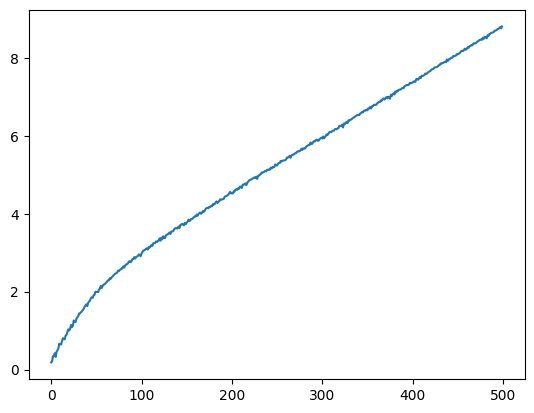

In [18]:
from matplotlib.pyplot import plot
plot(texture_results[0].loss_history)

In [7]:
def run_nn_config(config, save=None):

    texture_meis = []
    non_texture_meis = []
    for dim in texture_dims:
        texture_meis.append(MEI(operation=operation(dim), shape=(1, 40, 40), device="mps"))
    for dim in non_texture_dims:
        non_texture_meis.append(MEI(operation=operation(dim), shape=(1, 40, 40), device="mps"))

    texture_results = []
    non_texture_results = []

    for mei in texture_meis:
        texture_results.append(mei.generate_nn_based(**config))
    for mei in non_texture_meis:
        non_texture_results.append(mei.generate_nn_based(**config))

    plot_meis(texture_results, texture_dims, save=f"y_texture_decoding_{save}_nn.png" if save else None)
    plot_meis(non_texture_results, non_texture_dims, save=f"y_non_texture_decoding_{save}_nn.png" if save else None)
    return texture_results, non_texture_results

In [8]:
from meitorch.tools.generator_nn import GenerativeConvNet

In [9]:
nn_mei_config = dict(
    iter_n=500,
    save_every=100,        # save image every n iterations
    bias=0,               # bias of the image
    scale=1,              # scaling of the image
    n_samples =64,

    diverse=None,

    #transformations
    scaler=None,              # scaling of the image (float or schedule)
    jitter=None,             # size of translational jittering

    #normalization/clipping
    train_norm=None,        # norm adjustment during step
    norm=None,              # norm adjustment after step
    clip=None,

    #optmizer
    optimizer="adam",
    optimizer_params=dict(
        lr=0.01,        # scaling of gradient steps (float or schedule) = learning rate
        #step_size=LinearSchedule(2, 0.125)
    ),

    #preconditioning
    precond=None,            # strength of gradient preconditioning filter falloff (float or schedule)

    #denoiser
    denoiser=None,
    denoiser_params=dict(
        #sigma=LinearSchedule(1, 0.01)
        #reguralization_scaler=0.1,
        #lr=0.1,
        #num_iters=100,
    ),

    net = GenerativeConvNet([1, 8, 16, 8], shape=(1, 40,40), kernel_size=3)

)

100%|██████████| 500/500 [01:26<00:00,  5.81it/s]


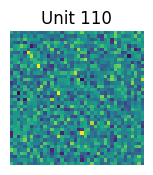

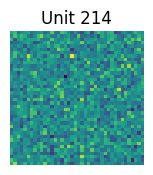

100%|██████████| 500/500 [01:29<00:00,  5.61it/s]


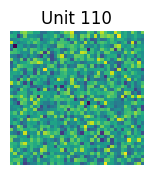

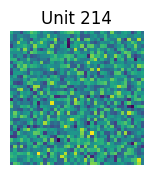

In [13]:
texture_results, non_texture_results = run_nn_config(nn_mei_config, save="var_01_10_kl_0")

In [71]:
from matplotlib.pyplot import imshow, show, title
def generate_from_unit_activation(unit, activation):
    y = torch.zeros((1, 250)).to("mps")
    y[:, unit] = activation
    computed = dict(y=y)
    computed, _ = model.generator.blocks["z"].sample_from_prior(computed, 1, use_mean=False)
    computed, _= model.output_block.sample_from_prior(computed, 1, use_mean=False)
    x = computed["x_hat"]
    op = operation(unit)
    activation = - op(x)
    imshow(x[0, 0].detach().cpu().numpy())
    title(f"Act: {activation}")
    show()
    return x.reshape(1, 1, 40, 40)

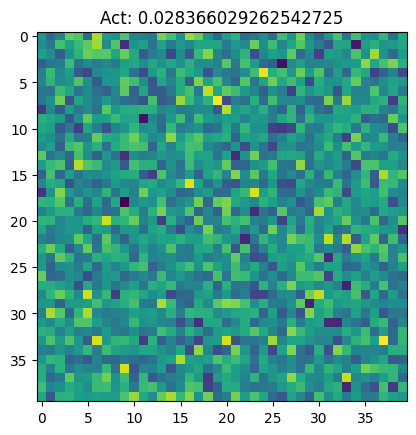

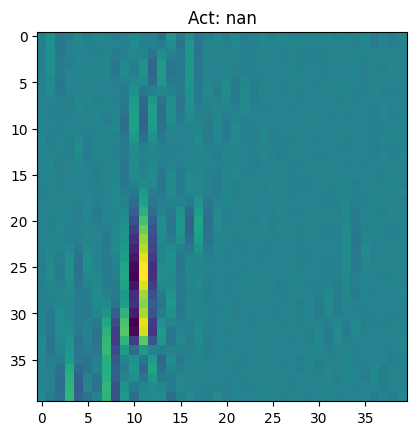

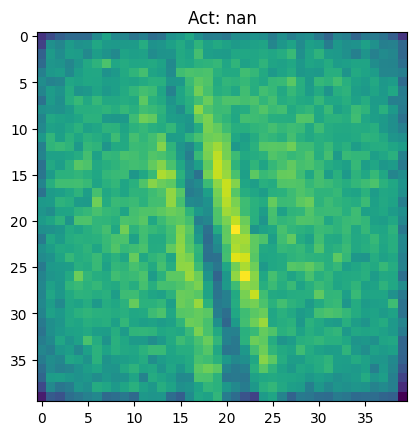

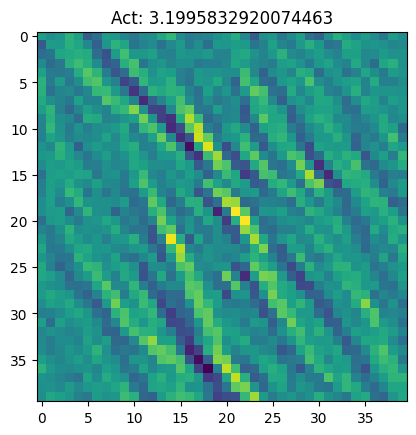

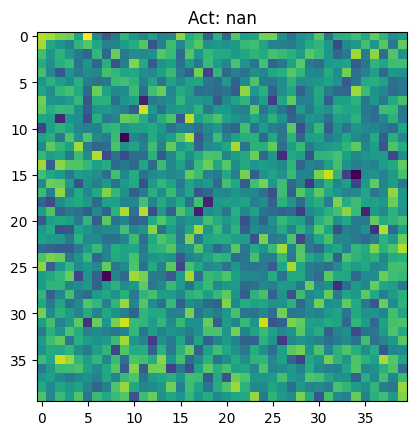

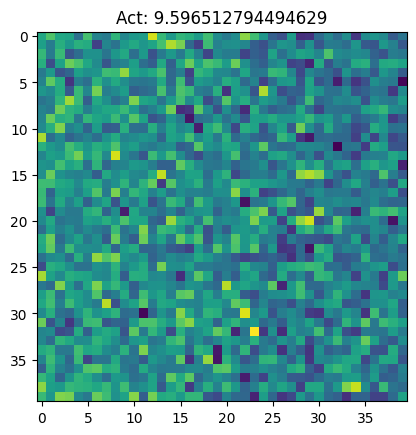

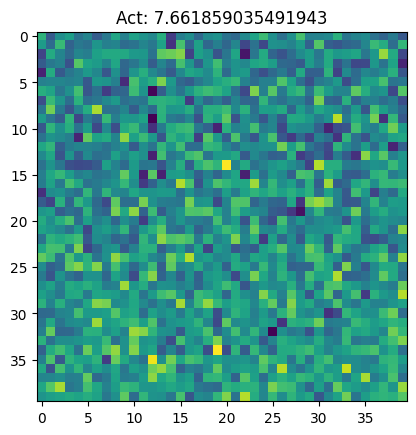

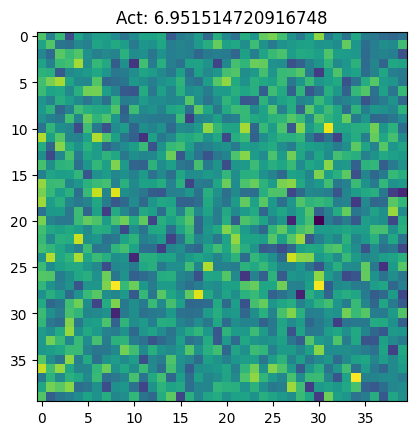

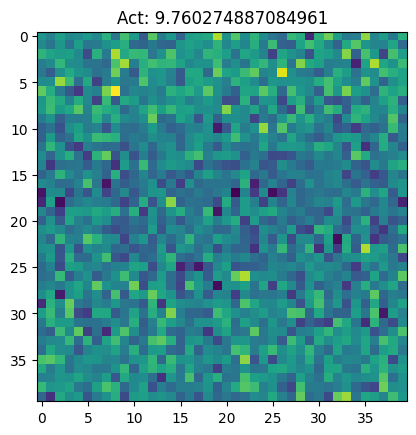

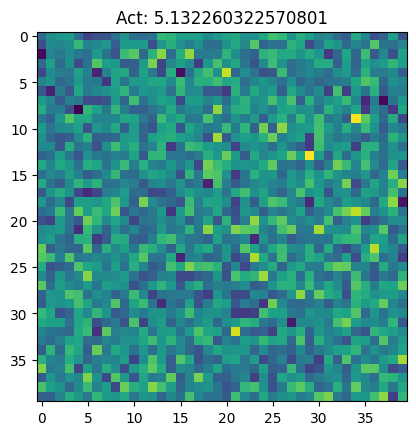

In [72]:

for unit in texture_dims:
    x = generate_from_unit_activation(unit, 10)
for unit in non_texture_dims:
    x = generate_from_unit_activation(unit, 10)

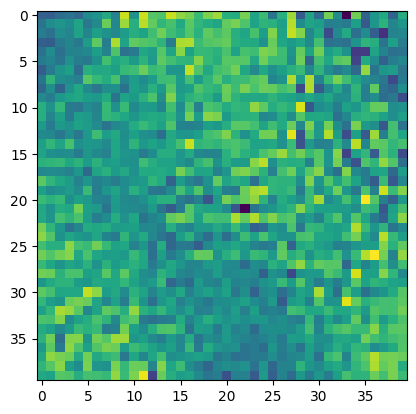

In [27]:

imshow(x[0, 0].detach().cpu().numpy())